In [1]:
from aistore.client import Client, Bck
import webdataset as wds
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

bck = Bck("nih")
chexpert = Bck("medical")
client = Client("http://datastore.lua.lab:8080")  # AIS IP address or hostname


In [2]:
from typing import Optional, Tuple, Callable

from io import StringIO
from aistore.client import Client, Bck
import webdataset as wds
from pytorch_lightning import LightningDataModule

import torch
from pytorch_lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms

import pandas as pd


class WebMedDataset(LightningDataModule):
    def __init__(
        self,
        # general part
        client: Client,
        bucket: Bck,
        transform=None,
        target_transform=None,
        data_aug=None,
        selector=None,
        image_handler="pil",
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
        seed=42,
        test_split=0.8,
        # dataset specific part
        unique_patients=True,
        views=["PA"],
        pathology_masks=False,
    ) -> None:
        super().__init__()

        self.save_hyperparameters(logger=False)

        self.batch_size = batch_size
        self.num_workers = num_workers
        if transform:
            self.transform = transform
        else:
            self.transform = lambda x: x
        self.data_aug = data_aug
        self.image_handler = image_handler
        if target_transform:
            self.target_transform = target_transform
        else:
            self.target_transform = lambda x: x

        if selector:
            self.selector = selector
        else:
            self.selector = lambda x: True
        self.seed = seed
        self.test_split = test_split
        self.pin_memory = pin_memory

        self.bucket = bucket
        self.client = client

        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.
        This method is called by lightning twice for `trainer.fit()` and `trainer.test()`, so be careful if you do a random split!
        The `stage` can be used to differentiate whether it's called before trainer.fit()` or `trainer.test()`."""
        # load datasets only if they're not loaded already
        if not self.data_train and not self.data_val and not self.data_test:
            dataset_size = len(self.shards_url[:-1])
            test_size = int(self.hparams.test_split * dataset_size)
            train_size = dataset_size - test_size

            train_urls, test_urls = random_split(
                self.shards_url[:-1],
                lengths=[train_size, test_size],
                generator=torch.Generator().manual_seed(self.hparams.seed),
            )
            val_urls = [self.shards_url[-1]]
            self.data_train = self.get_webdataset(
                train_urls.dataset,
                self.label_associator,
                self.transform,
                self.target_transform,
                image_handler=self.image_handler,
                selector=self.selector,
            )
            self.data_test = self.get_webdataset(
                test_urls.dataset,
                self.label_associator,
                self.transform,
                self.target_transform,
                image_handler=self.image_handler,
                selector=self.selector,
            )
            self.data_val = self.get_webdataset(
                val_urls,
                self.label_associator,
                self.transform,
                self.target_transform,
                image_handler=self.image_handler,
                selector=self.selector,
            )

    @classmethod
    def get_webdataset(
        cls,
        urls,
        label_associator,
        transform,
        target_transform,
        selector=lambda x: True,
        img_type="png",
        image_handler="pil",
    ):
        return (
            wds.WebDataset(urls)
            .decode(image_handler)
            .associate(label_associator)
            .select(selector)
            .shuffle(100)
            .rename(img=img_type)
            .map_dict(**{"img": transform, "label": target_transform})
        )

    
    def relabel_dataset(self, pathologies, silent=False):
        """
        Reorder, remove, or add (nans) to a dataset's labels.
        Use this to align with the output of a network.
        """
        will_drop = set(self.pathologies).difference(pathologies)
        if will_drop != set():
            if not silent:
                print("{} will be dropped".format(will_drop))
        new_labels = []
        self.pathologies = list(self.pathologies)
        for pathology in pathologies:
            if pathology in self.pathologies:
                pathology_idx = self.pathologies.index(pathology)
                new_labels.append(self.labels[:, pathology_idx])
            else:
                if not silent:
                    print("{} doesn't exist. Adding nans instead.".format(pathology))
                values = np.empty(self.labels.shape[0])
                values.fill(np.nan)
                new_labels.append(values)
        new_labels = np.asarray(new_labels).T

        self.labels = new_labels
        self.pathologies = pathologies
        self.associator = {kv[0] : kv[1] | {"label": nv} for kv,nv in zip(self.associator.items(),new_labels)}


    @property
    def num_classes(self) -> int:
        return len(self.pathology_dict)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )


In [3]:
class WebNIH(WebMedDataset):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.pathologies = [
            "Atelectasis",
            "Consolidation",
            "Infiltration",
            "Pneumothorax",
            "Edema",
            "Emphysema",
            "Fibrosis",
            "Effusion",
            "Pneumonia",
            "Pleural_Thickening",
            "Cardiomegaly",
            "Nodule",
            "Mass",
            "Hernia",
            "No Finding",
        ]
        self.pathologies = sorted(self.pathologies)
        self.pathology_dict = dict(zip(self.pathologies, range(0,
                                                          len(self.pathologies))))
        self.pathology_encoder = lambda x: self.pathology_dict[x]

        # Prepare webdataset stuff
        self.shards_url = list(
            filter(
                lambda x: "output" in x,
                (map(
                    lambda x: self.client.object_url(self.bucket, x["name"]),
                    self.client.list_objects(self.bucket),
                )),
            ))
        self.label_associator = self.get_associator()

    def get_associator(self) -> Callable:
        # Get csv file
        raw_csv = client.get_object(self.bucket, "Data_Entry_2017_v2020.csv")
        data = StringIO(str(raw_csv, "utf-8"))
        self.csv = pd.read_csv(data)

        images = self.csv["Image Index"].str.replace(".png", "")
        self.labels = []
        for pathology in self.pathologies:
            self.labels.append(self.csv["Finding Labels"].str.contains(pathology).values)

        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)

        age = self.csv["Patient Age"].values
        gender = (self.csv["Patient Gender"] == "M").values
        # labels = list(range(0,len(images)))
        self.associator = dict(
            zip(
                images,
                map(
                    lambda x: {
                        "label": x[0],
                        "meta": {
                            "age": x[1],
                            "gender": x[2]
                        }
                    },
                    zip(self.labels, age, gender),
                ),
            ))
        return lambda x: self.associator[x]


class WebCheXpert(WebMedDataset):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        pathologies = [
            "Enlarged Cardiomediastinum",
            "Cardiomegaly",
            "Lung Opacity",
            "Lung Lesion",
            "Edema",
            "Consolidation",
            "Pneumonia",
            "Atelectasis",
            "Pneumothorax",
            "Pleural Effusion",
            "Pleural Other",
            "Fracture",
            "Support Devices",
        ]
        self.pathologies = sorted(pathologies)
        self.pathology_dict = dict(zip(pathologies, range(0,
                                                          len(pathologies))))
        self.pathology_encoder = lambda x: self.pathology_dict[x]

        # Prepare webdataset stuff
        self.shards_url = list(
            filter(
                lambda x: "wd" in x,
                (map(
                    lambda x: self.client.object_url(self.bucket, x["name"]),
                    self.client.list_objects(self.bucket),
                )),
            ))
        self.label_associator = self.get_associator()

    @classmethod
    def get_webdataset(
        cls,
        urls,
        label_associator,
        transform,
        target_transform,
        image_handler,
        selector,
    ):
        return super().get_webdataset(
            urls,
            label_associator,
            transform,
            target_transform,
            img_type="jpg",
            image_handler=image_handler,
            selector=selector,
        )

    def get_associator(self) -> Callable:

        def path_to_name(path):
            _, mode, patient, study, view = path.split("/")
            study_num = "".join(filter(str.isdigit, study))
            new_name = patient + "_" + study_num + "_" + view
            return new_name.replace(".jpg", "")

        # Get csv file
        csv = pd.read_csv(
            StringIO(str(client.get_object(self.bucket, "train.csv"),
                         "utf-8")))
        csv2 = pd.read_csv(
            StringIO(str(client.get_object(self.bucket, "valid.csv"),
                         "utf-8")))
        self.csv = pd.concat([csv, csv2])

        images = self.csv.Path.apply(path_to_name).values
        self.labels = self.csv[self.pathologies].values
        # labels = list(range(0,len(images)))
        age = self.csv["Age"].values
        gender = (self.csv["Sex"] == "Male").values
        # labels = list(range(0,len(images)))
        self.associator = dict(
            zip(
                images,
                map(
                    lambda x: {
                        "label": x[0],
                        "meta": {
                            "age": x[1],
                            "gender": x[2]
                        }
                    },
                    zip(self.labels, age, gender),
                ),
            ))
        return lambda x: self.associator[x]


In [5]:
import torchxrayvision as xrv

model = xrv.models.DenseNet(weights="densenet121-res224-all")
#model = xrv.models.ResNet(weights="resnet50-res512-all")

model.to("cuda")
preproc = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Grayscale()

])

transform = transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])


def label_encoder(label):
    print(label)
    return torch.sum(torch.nn.functional.one_hot(torch.tensor(label),num_classes=15),dim=0)



a = WebCheXpert(client=client,bucket=chexpert,transform=transform,image_handler=xrayvision_preproc,batch_size=20)
a.setup()
def label_encoder(label):
    return torch.sum(torch.nn.functional.one_hot(torch.tensor(label),num_classes=15),dim=0)

male_nih = WebNIH(client=client,bucket=bck,transform=transform,image_handler=xrayvision_preproc,batch_size=20,target_transform=label_encoder)
male_nih.setup()


In [6]:
for b in a.val_dataloader():
    pass

In [7]:
from typing import Any, List

import torch
from pytorch_lightning import LightningModule
from torchmetrics import MinMetric
from torchmetrics.regression import CosineSimilarity

from sklearn.linear_model import LogisticRegression

class ConceptVectorModule(LightningModule):
    """
    Example of LightningModule for MNIST classification.

    A LightningModule organizes your PyTorch code into 5 sections:
        - Computations (init).
        - Train loop (training_step)
        - Validation loop (validation_step)
        - Test loop (test_step)
        - Optimizers (configure_optimizers)

    Read the docs:
        https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html
    """

    def __init__(
        self,
        model: LightningModule, 
        concept: str,
        target_class: int = 1
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # it also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        self.automatic_optimization=False

        self.model = model

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # concept to find vectors for
        self.concept = concept 

        # use separate metric instance for train, val and test step
        # to ensure a proper reduction over the epoch
        self.train_sim_cav = CosineSimilarity()
        self.train_sim_diff = CosineSimilarity()
        self.val_sim = CosineSimilarity()
        self.test_sim = CosineSimilarity()

        # for logging best so far validation accuracy
        self.val_sim_best = MinMetric()

        # Different concept vectors 
        self.cav = torch.ones((1024, 7, 7)).flatten(start_dim=0)
        self.diff = torch.ones_like(self.cav)
        self.grad_vec = torch.ones_like(self.cav)

    def calculate_vectors(self,emb_pos,emb_neg):
        cav_model = LogisticRegression()
        x_train = np.concatenate([emb_pos.detach().flatten(start_dim=1).numpy(), emb_neg.detach().flatten(start_dim=1).numpy()])
        concept = np.concatenate([np.ones(emb_pos.shape[0]),np.zeros(emb_neg.shape[0])])
        cav_model.fit(x_train, concept)
        if len(cav_model.coef_) == 1:
            cav = torch.tensor(-cav_model.coef_[0])
        else:
            cav = -torch.tensor(cav_model.coef_)
        diff = (torch.mean(emb_pos,dim=0) - torch.mean(emb_neg,dim=0)).flatten(start_dim=0)
        return cav, diff, 0

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def step(self, batch: Any):
        img = batch['img']
        concept = batch['meta'][self.concept]
        y_pos = batch['label'][concept]
        y_neg = batch['label'][~concept]
        emb_pos = self.model.features(img[concept])
        emb_neg = self.model.features(img[~concept])

        return emb_pos, emb_neg, y_pos, y_neg

    def training_step(self, batch: Any, batch_idx: int):
        emb_pos, emb_neg, y_pos, y_neg = self.step(batch)
        cav, diff, _ = self.calculate_vectors(emb_pos,emb_neg)
        # log train metrics
        cosine_cav = self.train_sim_cav(self.cav, cav)
        cosine_diff = self.train_sim_diff(self.diff, diff)

        self.log("train/cosine_cav", cosine_cav, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train/cosine_diff", cosine_diff, on_step=False, on_epoch=True, prog_bar=False)


        # we can return here dict with any tensors
        # and then read it in some callback or in `training_epoch_end()`` below
        # remember to always return loss from `training_step()` or else backpropagation will fail!
        return {"cav": cav, "diff": diff}

    def training_epoch_end(self, outputs: List[Any]):
        # `outputs` is a list of dicts returned from `training_step()`
        self.cav = torch.mean(outputs['cav'],dim=0)
        self.diff = torch.mean(outputs['diff'],dim=0)
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        emb_pos, emb_neg, y_pos, y_neg = self.step(batch)
        cav, diff, _ = self.calculate_vectors(emb_pos,emb_neg)

        # log val metrics
        cosine_cav = self.val_sim(self.cav, cav)
        cosine_diff = self.val_sim(self.diff, diff)

        self.log("val/cosine_cav", cosine_cav, on_step=True, on_epoch=True, prog_bar=False)
        self.log("val/cosine_diff", cosine_diff, on_step=True, on_epoch=True, prog_bar=False)


        return {"cosine_cav": cosine_cav, "cosine_diff": cosine_diff}

    def validation_epoch_end(self, outputs: List[Any]):
        pass
    
    def test_step(self, batch: Any, batch_idx: int):
        pass
    
    def test_epoch_end(self, outputs: List[Any]):
        pass

    def on_epoch_end(self):
        # reset metrics at the end of every epoch
        self.train_sim_cav.reset()
        self.train_sim_cav.reset()
        self.val_sim.reset()


In [8]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")
concepter = ConceptVectorModule(model,"gender")

In [10]:
concepter.training_step(b,0)

{'cav': tensor([ 0.0010, -0.0013, -0.0011,  ...,  0.0001,  0.0002,  0.0003],
        dtype=torch.float64),
 'diff': tensor([-0.0872,  0.0150,  0.0570,  ...,  0.0482,  0.0234, -0.0164],
        grad_fn=<ReshapeAliasBackward0>)}

In [ ]:
a

In [29]:
b['img'][~b['meta']['gender']].shape

torch.Size([6, 1, 224, 224])

In [49]:
model.features(b['img'][:1].to("cuda")).shape

torch.Size([1, 1024, 7, 7])

In [12]:
b['img'][~b['meta']['gender']].average

AttributeError: 'Tensor' object has no attribute 'average'

In [12]:
for b in male.val_dataloader():
    pass

In [31]:
for x,_ in ae.named_modules():
    print(x)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [16]:
ae.eval()
with torch.no_grad():
    z = ae.encode(b['img'])
    image2 = ae.decode(z)


In [47]:
from tcav.model_wrapper import ModelWrapper
from tcav.tcav import TCAV
extract_layer = 'features'
model = ModelWrapper(model, [extract_layer])
class_dict = {
    "bike": 1,
    "calculator": 5,
    "desk_chair": 6,
    "headphones": 10,
    "laptop_computer": 12,
    "phone": 20,
}

In [48]:
scorer = TCAV(model, male.val_dataloader(), {"male":male_nih.test_dataloader(),"female":female_nih.test_dataloader()}, class_dict.values(), 100)

print("Generating concepts...")
scorer.generate_activations([extract_layer])


Generating concepts...


In [49]:
scorer.generate_cavs(extract_layer)

In [50]:
scorer.cavs

array([[-0.00041039, -0.02190308, -0.04937124, ...,  0.02454369,
         0.02546029,  0.00295316],
       [ 0.00041039,  0.02190308,  0.04937124, ..., -0.02454369,
        -0.02546029, -0.00295316]])

In [14]:
scorer.cavs

array([[ 0.00355629,  0.00422626,  0.01974702, ..., -0.00292689,
         0.00187536, -0.00275519],
       [-0.00355629, -0.00422626, -0.01974702, ...,  0.00292689,
        -0.00187536,  0.00275519]])

In [31]:
torch.tensor(scorer.activations['female']).flatten(start_dim=1).shape

torch.Size([10000, 50176])

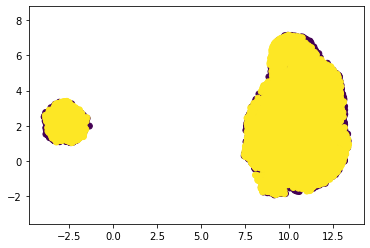

In [34]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP()
embedding = reducer.fit_transform(torch.cat([torch.tensor(scorer.activations['female']).flatten(start_dim=1),torch.tensor(scorer.activations['male']).flatten(start_dim=1)]))
embedding.shape
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],c=[0 if x < 10000 else 1 for x in range(0,len(embedding))])
plt.gca().set_aspect('equal', 'datalim')


In [36]:
scorer.activations

{'male': array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.04844704, ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.53481585, 0.51587856, ..., 0.     